In [ ]:
%%time

# Generiche
import random
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import os
import glob
import cv2

# Keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Flatten, Convolution2D, MaxPooling2D, Dropout, Activation, AveragePooling2D
from keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers 
import keras
from keras import layers

# Sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, Normalizer, StandardScaler

np.random.seed(1234)
tf.random.set_seed(1234)

CPU times: user 1.81 s, sys: 339 ms, total: 2.15 s
Wall time: 3.1 s


In [ ]:
%%time

!unzip "/content/drive/MyDrive/Colab Notebooks/PROGETTO MUSICA DSIM/DATASET/MEL_DATASET_3_SEC.zip" -d "/content"

In [ ]:
%%time

music_train = []
music_label = []
for dir_path in glob.glob("/content/Train_3_seconds_Mel/*"):
    img_label = dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)
        image = cv2.resize(image, (50,50))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        music_train.append(image)
        music_label.append(img_label)
music_train = np.array(music_train)
music_label = np.array(music_label)

CPU times: user 8.46 s, sys: 518 ms, total: 8.97 s
Wall time: 9.11 s


In [ ]:
%%time

label_to_id = {v:k for k,v in enumerate(np.unique(music_label)) }
id_to_label = {v:k for k,v in label_to_id.items()}

CPU times: user 1.79 ms, sys: 989 µs, total: 2.78 ms
Wall time: 2.53 ms


In [ ]:
id_to_label

{0: 'Blues',
 1: 'Classical',
 2: 'Country',
 3: 'Disco',
 4: 'HipHop',
 5: 'Jazz',
 6: 'Metal',
 7: 'Pop',
 8: 'Reggae',
 9: 'Rock'}

In [ ]:
%%time

music_label_id = np.array([label_to_id[i] for i in music_label])

CPU times: user 8.35 ms, sys: 0 ns, total: 8.35 ms
Wall time: 8.67 ms


In [ ]:
%%time

X_train, X_test, y_train, y_test = train_test_split(music_train, music_label_id, test_size=0.1, random_state=101)

CPU times: user 11.7 ms, sys: 20.1 ms, total: 31.8 ms
Wall time: 40.4 ms


In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8991, 50, 50, 3), (8991,), (999, 50, 50, 3), (999,))

In [ ]:
X_train = X_train/255
X_test = X_test/255

In [ ]:
le = LabelEncoder()

le.fit(y_train)

y_train_enc = le.transform(y_train)

y_test_enc = le.transform(y_test)

In [ ]:
%%time

def build(width, height, depth, classes):
    #initialize the model along with the input shape
    initializer = tf.keras.initializers.GlorotUniform(seed=1234) 
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    
    if K.image_data_format() == 'channels_first':
        inputShape = (depth, height, width)
        chanDim = 1  

    model.add(Convolution2D(64, (3,3), padding='same', kernel_initializer=initializer, kernel_regularizer= regularizers.l2(), bias_regularizer= regularizers.l2(),   input_shape=inputShape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
  
    model.add(Convolution2D(32, (3,3), padding='same', kernel_initializer=initializer, kernel_regularizer= regularizers.l2(), bias_regularizer= regularizers.l2()))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(16, (3,3), padding='same', kernel_initializer=initializer, kernel_regularizer= regularizers.l2(), bias_regularizer= regularizers.l2()))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    
    model.add(Dense(64, kernel_initializer=initializer, kernel_regularizer= regularizers.l2(), bias_regularizer= regularizers.l2()))
    model.add(Activation('relu'))
    model.add(Dropout(0.10))
   
    model.add(Dense(classes))
    model.add(Activation('softmax'))
    
    return model

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


In [ ]:
import keras.backend as K
model = build(50,50,3,10)

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25, 25, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        18464     
_________________________________________________________________
activation_1 (Activation)    (None, 25, 25, 32)        0

In [ ]:
%%time

history = model.fit(X_train, y_train_enc, epochs=200, batch_size=64,  validation_split=0.10)

Epoch 1/200
127/127 [==============================] - 10s 24ms/step - loss: 4.4650 - accuracy: 0.1515 - val_loss: 4.2072 - val_accuracy: 0.1122
Epoch 2/200
127/127 [==============================] - 2s 17ms/step - loss: 3.8644 - accuracy: 0.2375 - val_loss: 4.3992 - val_accuracy: 0.1078
Epoch 3/200
127/127 [==============================] - 2s 17ms/step - loss: 3.6275 - accuracy: 0.2884 - val_loss: 4.5274 - val_accuracy: 0.1156
Epoch 4/200
127/127 [==============================] - 2s 16ms/step - loss: 3.4382 - accuracy: 0.3296 - val_loss: 4.2985 - val_accuracy: 0.1844
Epoch 5/200
127/127 [==============================] - 2s 16ms/step - loss: 3.2727 - accuracy: 0.3635 - val_loss: 3.7685 - val_accuracy: 0.2644
Epoch 6/200
127/127 [==============================] - 2s 16ms/step - loss: 3.1050 - accuracy: 0.3917 - val_loss: 3.4920 - val_accuracy: 0.3089
Epoch 7/200
127/127 [==============================] - 2s 16ms/step - loss: 2.9562 - accuracy: 0.4348 - val_loss: 3.4823 - val_accuracy

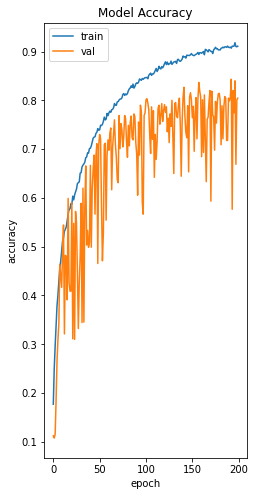

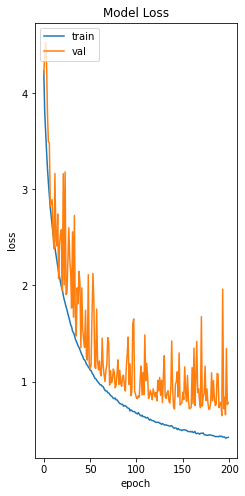

CPU times: user 404 ms, sys: 11.3 ms, total: 415 ms
Wall time: 442 ms


In [ ]:
%%time

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
score_CNN_5 = model.evaluate(X_test, y_test_enc, verbose=0)
print("Test loss:", score_CNN_5[0])
print("Test accuracy:", score_CNN_5[1])

Test loss: 0.7493147850036621
Test accuracy: 0.8028028011322021


In [ ]:
predictions = model.predict_classes(X_test)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
%%time
target_names = ['Blues', 'Classical', 'Country', 'Disco', 'Hiphop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']
print(classification_report(predictions, y_test_enc, target_names=target_names))

              precision    recall  f1-score   support

       Blues       0.50      1.00      0.67        49
   Classical       0.91      0.91      0.91        95
     Country       0.61      0.86      0.72        69
       Disco       0.78      0.93      0.85        69
      Hiphop       0.89      0.85      0.87       109
        Jazz       0.97      0.67      0.79       132
       Metal       0.84      0.93      0.89        92
         Pop       0.85      0.83      0.84       117
      Reggae       0.83      0.82      0.82       117
        Rock       0.83      0.55      0.66       150

    accuracy                           0.80       999
   macro avg       0.80      0.84      0.80       999
weighted avg       0.83      0.80      0.80       999

CPU times: user 7.96 ms, sys: 190 µs, total: 8.15 ms
Wall time: 8.22 ms


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/PROGETTO MUSICA DSIM/MODELLI/Music_CNN_5.model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/PROGETTO MUSICA DSIM/MODELLI/Music_CNN_5.model/assets
